In [10]:
import json
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import nltk
from textblob import TextBlob
import scipy.stats

%matplotlib inline

In this work, I am trying to make a heatmap for decent restaurants in the state of AZ. This can be used by tourists to know which way they should drive to become adventurous and try local restaurants.

Also I will try to normalize the star numbers to a different measure that gives weight to a user's comment based on their historical comments' polarity.

$ M = \frac{1}{N}\sum_i^N{(1 - Prob(x_i,\mu_i,\sigma_i)).x_i}$

This way we can gauge the weight of the comments based on the users historical behavior. For instance, if a user always leaves negative comments and suddenly puts a sparkling review for a restaurant it should carry more weight than someone who only sees the positive aspects of EVERY location.

In [11]:
f = open("./business.json","r")
data = f.read().strip().split("\n")
f.close()

AZ_businesses = [json.loads(i) for i in data if json.loads(i)["state"] == "AZ" ]    
print(len(AZ_businesses))


32615


In [12]:
bus_loc = {}
for i in AZ_businesses:
    bus_loc[i['business_id']] = (i['latitude'],i['longitude'])

In [13]:
AZ_ID = [i["business_id"] for i in AZ_businesses]

In [14]:
punctuations = string.punctuation + "\n\r\t"

In [15]:
output = open("AZ_review.csv","w")
output.write('business_id, user_id, stars,latitude, longitude, text\n')
output.close()

In [16]:
output = open("AZ_review.csv","a",encoding="utf-8")
with open("./review.json","r",buffering=10000) as f:
    for line in f.readlines():
        json_obj = json.loads(line)
        if json_obj["business_id"] in AZ_ID:
            remove_punct_map = dict.fromkeys(map(ord, punctuations))

            output.write("%s , %s , %s, %s , %s , %s\n" %(json_obj["business_id"],
                                                          json_obj["user_id"] ,
                                                          json_obj["stars"] ,
                                                          bus_loc[json_obj["business_id"]][0] ,
                                                          bus_loc[json_obj["business_id"]][1] ,
                                                          json_obj["text"].translate(remove_punct_map)))
            

output.close()


In [17]:
df = pd.read_csv("AZ_review.csv",sep = ",",header=None,skiprows=1)


In [18]:
df.columns = ["business_id", "user_id","stars","latitude", "longitude","text_comments"]
df.head()

,business_id,user_id,stars,latitude,longitude,text_comments
0,KyXO7gXGVdpPJ1enxIf3Ig,qn4fbznVr3Ek9toVZJ9AuA,2,33.63863,-112.179234,Quick but we were desparate for a room that a...
1,KyXO7gXGVdpPJ1enxIf3Ig,mCShrTt9aMtDCssz9t-jJA,1,33.63863,-112.179234,This motel deserves 0 stars The receptionist ...
2,KyXO7gXGVdpPJ1enxIf3Ig,jCouJ6fTVpU70C0rHaUHcw,4,33.63863,-112.179234,My mother and I stayed here for a couple of n...
3,KyXO7gXGVdpPJ1enxIf3Ig,-bmfGCByi7qv1fDzR49eGw,3,33.63863,-112.179234,We needed a place to stay the night before mo...
4,KyXO7gXGVdpPJ1enxIf3Ig,CCBSd5m3DVfqtgT1SJcjZw,1,33.63863,-112.179234,Loud as fck sprinklers at 1am that prevent sl...


In [35]:

import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    y = np.histogram(df.stars.values,bins=4)[0],
    x = np.histogram(df.stars.values,bins=4)[1]

)

data = [trace1]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [36]:
def pos_neg(x):
    sentence = TextBlob(x)
    return sentence.polarity

In [37]:
def pos_neg_class(x):
    x = float(x)
    if abs(x) < 0.38:
        return 0
    elif x > 0:
        return 1
    else:
        return -1

In [38]:
def pol_norm(x):
    means = np.mean(x)
    stds = np.std(x)
    return np.array(list(map(lambda s: (s-means)/stds,x)))

In [39]:
df.text_comments = df.text_comments.apply(str)

In [40]:
df["polarity"] = df.text_comments.apply(pos_neg)


In [41]:
df["pos_neg_class"] = df.polarity.apply(pos_neg_class)

In [42]:
df["scaledPol"] = pol_norm(df.polarity.values)

In [43]:
df.to_csv("intermediate.csv",index_label=None)

In [155]:
def norm_polarity(x,y,cutoff = 0.00001):
    if int(dictcounts[x]) > 1:
        return 1 - scipy.stats.norm(dictmeans[x],dictstds[x]).pdf(y)
    else:
        return cutoff

In [151]:
dictmeans = df.groupby("user_id")["polarity"].mean().to_dict()
dictstds = df.groupby("user_id")["polarity"].std().to_dict()
dictcounts = df.groupby("user_id")['business_id'].count().to_dict()

In [156]:
df["prob_pol"] = df.apply(lambda row: norm_polarity(row['user_id'], row['polarity']), axis=1)

In [157]:
df.to_csv("intermediate.csv",index_label=None)

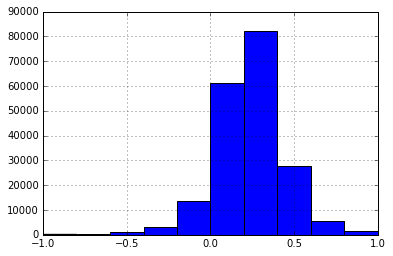

In [47]:
df.groupby("user_id").mean().reset_index()["polarity"].hist()

In [71]:
df.groupby("user_id").sum().reset_index()["polarity"].nlargest(50).reset_index()

,index,polarity
0,163697,253.335719
1,180094,205.829517
2,17733,195.859310
3,14338,181.876344
4,133873,181.587269
5,114974,174.861250
6,30725,171.351685
7,40094,157.244304
8,45475,145.903039
9,4962,143.712188


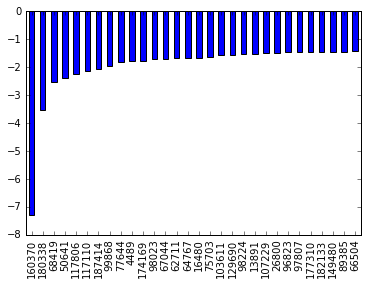

In [58]:
df.groupby("user_id").sum().reset_index()["polarity"].nsmallest(30).plot(kind='bar')

In [90]:
df.groupby("user_id").count().reset_index()[["user_id","polarity"]]

,user_id,polarity
0,--0HEXd4W6bJI8k7E0RxTA,2
1,--4TkB_iDShmg41Y_QW9nw,33
2,--65q1FpAL_UQtVZ2PTGew,149
3,--6QV7LYVrHWs3WmWb61mg,2
4,--7266Nwi6RXjKNNKeoFMQ,1
5,--82_AVgRBsLw6Dhy8sEnA,1
6,--AqBuo717RyacADExYbSA,7
7,--DRrM6qUbL7H_21cngSxA,2
8,--FH3mc-pdjsb2RAWfOiQA,1
9,--Gjrja8RffTz9nKHXsXpA,4


In [14]:
import plotly.plotly as py
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

data = [ dict(
        type = 'choropleth',
        locations = df['CODE'],
        z = df['GDP (BILLIONS)'],
        text = df['COUNTRY'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '$',
            title = 'GDP<br>Billions US$'),
      ) ]

layout = dict(
    title = '2014 Global GDP<br>Source:\
            <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )


In [17]:
df['CODE']

0      AFG
1      ALB
2      DZA
3      ASM
4      AND
5      AGO
6      AIA
7      ATG
8      ARG
9      ARM
10     ABW
11     AUS
12     AUT
13     AZE
14     BHM
15     BHR
16     BGD
17     BRB
18     BLR
19     BEL
20     BLZ
21     BEN
22     BMU
23     BTN
24     BOL
25     BIH
26     BWA
27     BRA
28     VGB
29     BRN
      ... 
192    SWE
193    CHE
194    SYR
195    TWN
196    TJK
197    TZA
198    THA
199    TLS
200    TGO
201    TON
202    TTO
203    TUN
204    TUR
205    TKM
206    TUV
207    UGA
208    UKR
209    ARE
210    GBR
211    USA
212    URY
213    UZB
214    VUT
215    VEN
216    VNM
217    VGB
218    WBG
219    YEM
220    ZMB
221    ZWE
Name: CODE, dtype: object